<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    SAN Projekt:<br> Schweizer Offshore Firmen
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Tobias Buess im FS 2024.
</p>

Wir führen eine Voranalyse für das Bundesamt für Statistik durch, um die kürzlich aufgetretenen Leaks aus den Offshore Papers zu untersuchen. 

Diese Analyse zielt darauf ab, Umfang und Natur der Verbindungen in Schweizer Offshore-Strukturen zu ermitteln. Wir verwenden dafür Daten aus der [Offshore Leaks Database](https://offshoreleaks.icij.org/), um mögliche Muster, wichtige Personen aufzudecken, die für die Steuerbehörden oder Regulierungsorgane von Interesse sein könnten. 

Unsere Arbeit umfasst eine detaillierte Prüfung der betroffenen Entitäten. Dies wird es dem Bundesamt für Statistik ermöglichen, fundierte Entscheidungen zur weiteren Untersuchung und möglichen Massnahmen zu treffen.

## Imports und Einstellungen

In [1]:
# Python internal modules
import os

# Project modules
import utils

# External modules
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

BACKEND = None  # use default
if "cugraph" in nx.utils.backends.backends.keys():
    import nx_cugraph as nxcg

    BACKEND = "cugraph"

print("Python Environment:")
print(f" | Python version: {os.sys.version}")
print(f" | Numpy version: {np.__version__}")
print(f" | Pandas version: {pd.__version__}")
print(f" | Matplotlib version: {matplotlib.__version__}")
print(f" | NetworkX version: {nx.__version__}")
print(f" | NetworkX backend: {BACKEND}")
print(
    f" | CuGraph version: {nxcg.__version__}"
    if BACKEND == "cugraph"
    else " | CuGraph not installed, for better performance install it like this:\n\tpip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com"
)
print()
print("Ressources:")
print(f" | CPU: {os.cpu_count()} cores")

PAPERS = "Pandora Papers"
GRAPH_PATH = f"./data/{PAPERS.lower().replace(' ', '_')}_graph.gexf"

plt.rcParams["figure.figsize"] = (25, 10)
plt.rcParams["figure.dpi"] = 200
plt.rcParams.update({"font.size": 13})

Python Environment:
 | Python version: 3.11.9 (main, May  9 2024, 10:22:36) [GCC 11.4.0]
 | Numpy version: 1.26.4
 | Pandas version: 2.2.2
 | Matplotlib version: 3.9.0
 | NetworkX version: 3.3
 | NetworkX backend: cugraph
 | CuGraph version: 24.04.00

Ressources:
 | CPU: 32 cores


## Daten laden

In [2]:
# Graph mit allen Nodes/Edges von den gewählten Papers laden
G = utils.get_graph(GRAPH_PATH, PAPERS)

# Haben schweizer Officer mehr Firmen zusammen mit anderen schweizer Officers oder mit ausländischen Officers?

## Filtering / Merging / Projection

In [3]:
# filter Graph by officers and entities (remove parallel connections -> multiple connections will result in one)
officer_entity = nx.Graph(
    G.subgraph(
        utils.filter_nodes(G, "(node_type == 'Officer') or (node_type == 'Entity')")
    ).to_undirected()
)

Behalte nur Officer und Entities

In [4]:
# merge same nodes
officer_entity = utils.merge_duplicate_nodes(
    officer_entity,
    exclude_attributes=["label", "countries", "sourceID", "valid_until", "note"],
)

Merging duplicate nodes:   0%|          | 0/60872 [00:00<?, ?it/s]

Merge Nodes mit selben Attributen (ohne label, countries, sourceID, valid_until und note).

In [5]:
# get officer nodes
officer_nodes = utils.filter_nodes(officer_entity, "node_type == 'Officer'")

# Projection -> If two officers are connected to an entity -> Edge
officer_officer = nx.Graph(
    nx.projected_graph(officer_entity, officer_nodes).subgraph(officer_nodes)
)

Projeziere zu einem one mode Netzwerk, sodass nur noch Officers übrig bleiben. Jeder Officer, welcher mindestens einmal mit einem anderen Officer ein gemeinsames Entity besitzt, bekommen eine Verbindung.

In [6]:
cc = np.array(
    list(
        filter(
            lambda x: len(x) > 3,
            nx.get_node_attributes(officer_officer, "country_codes").values(),
        )
    )
)  # get country codes
c_c = np.array([(c[:3], c[3:]) for c in cc])  # split first and second country code

print(
    "Country codes are alphabetically sorted: ",
    ~(~(c_c == np.sort(c_c, axis=1))).any(axis=1).any(),
)

Country codes are alphabetically sorted:  False


Überprüfe ob country_codes alphabetisch geordnet sind.

In [7]:
# use the first 3 letters of the country codes for the sake of simplicity (country codes are not alphabetical)
nx.set_node_attributes(
    officer_officer,
    {
        node: {
            key: value if key != "country_codes" else value[:3]
            for key, value in attr.items()
        }
        for node, attr in officer_officer.nodes(data=True)
    },
)

Ordne jeder Officer einem Land zu, wenn dieser zu mehreren Ländern assigned ist

In [8]:
# remove officers with no country code
cc = nx.get_node_attributes(officer_officer, "country_codes")
officer_officer.remove_nodes_from(
    np.array(list(cc.keys()))[np.array(list(cc.values())) == "nan"]
)

Entferne alle Officers, welche keinem Land zugeordnet sind

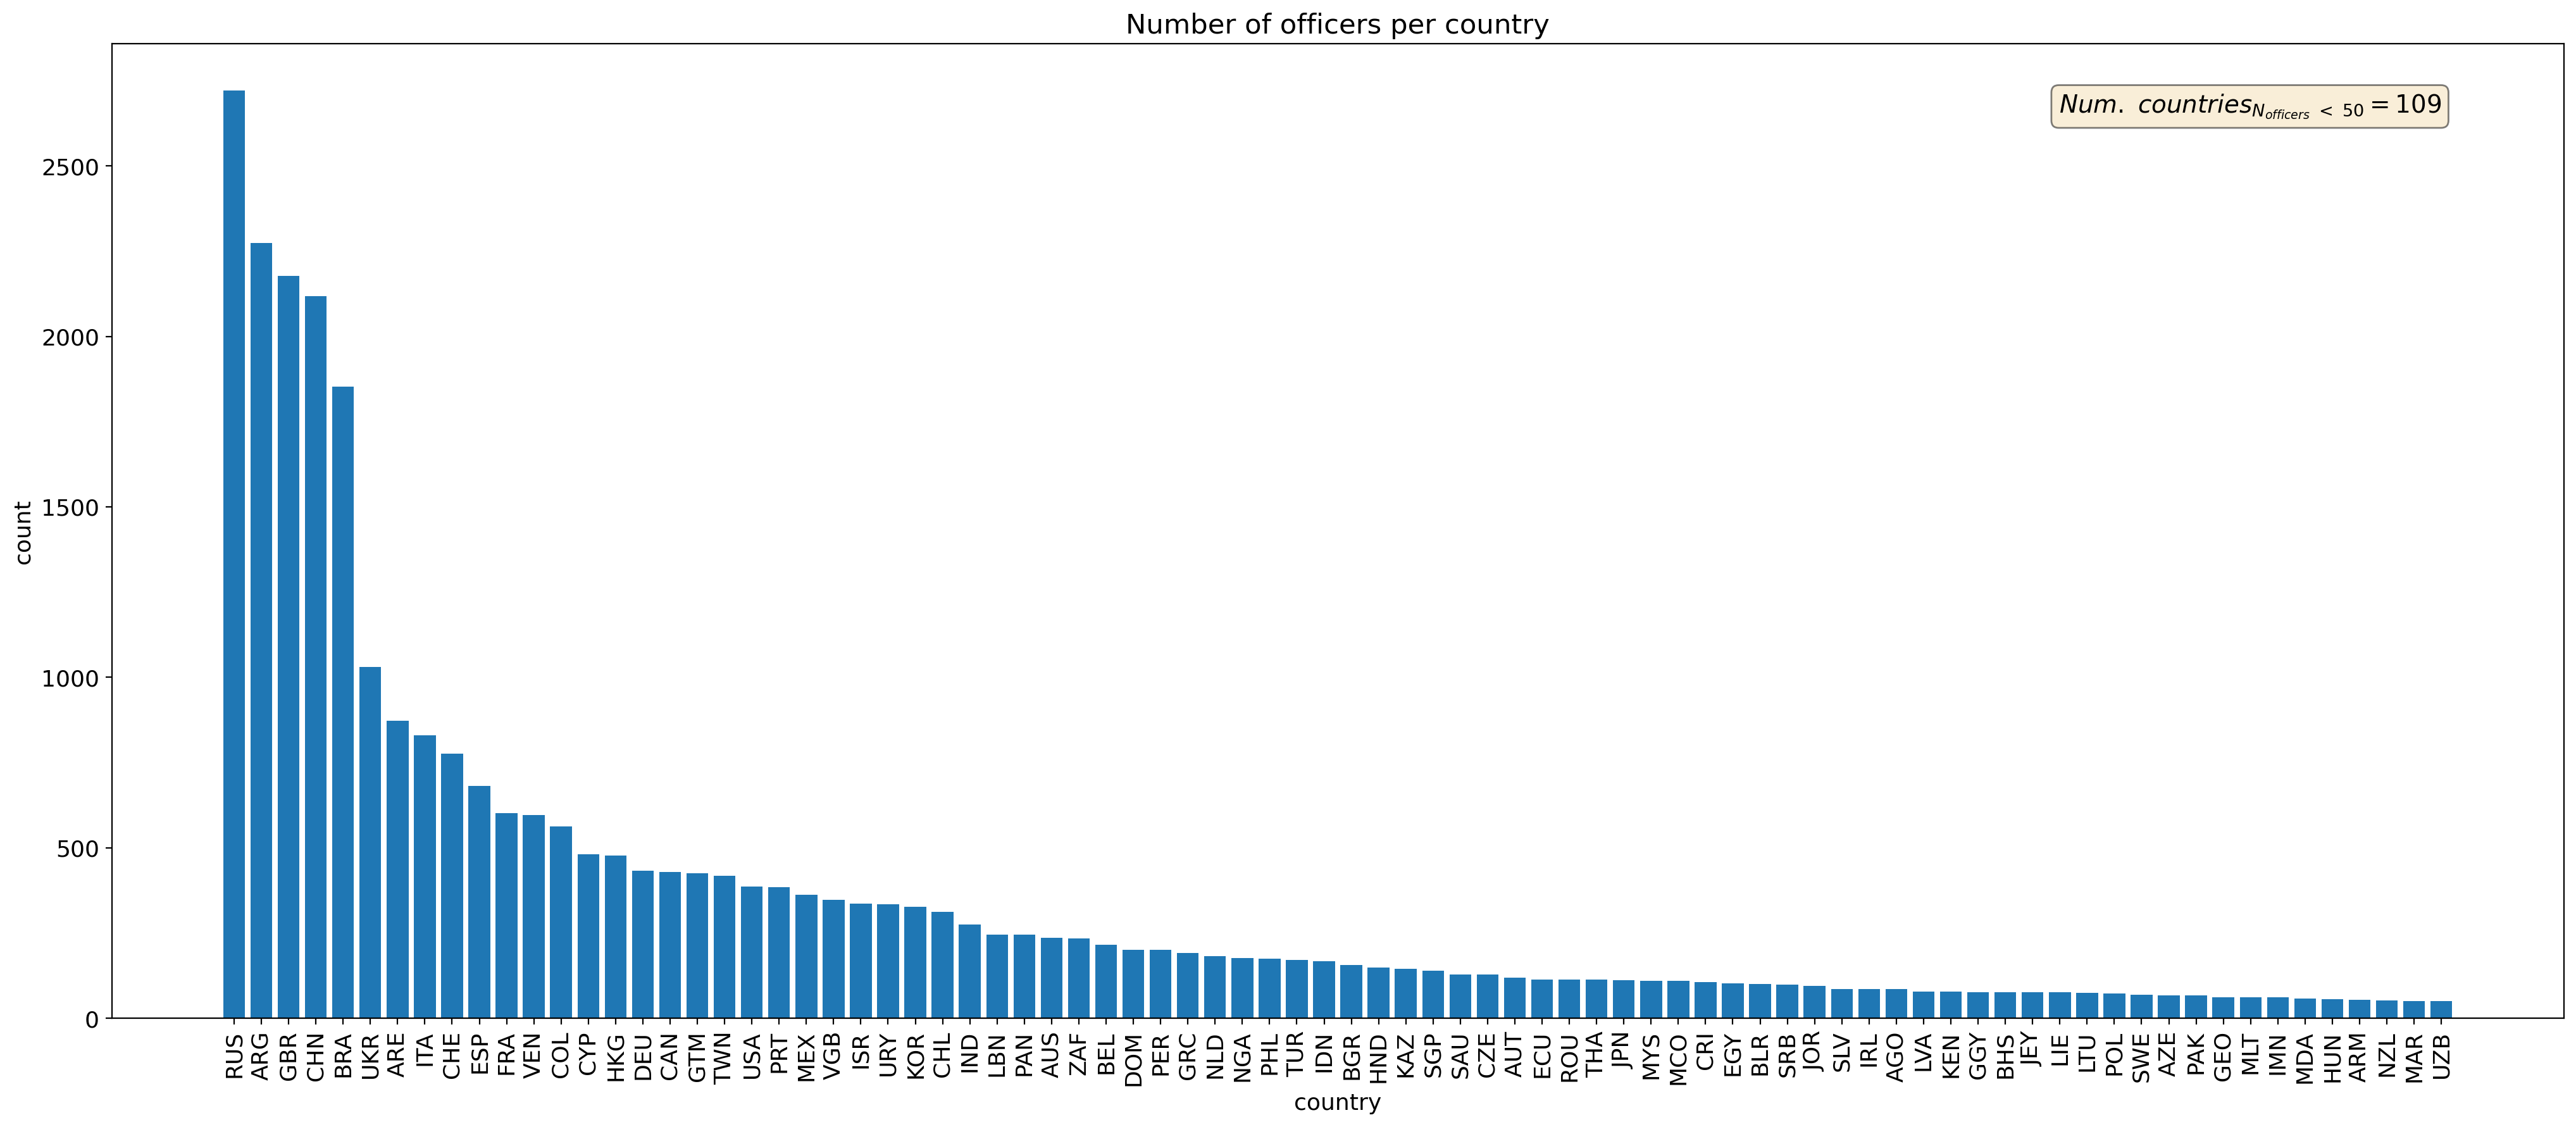

In [9]:
x, y = np.unique(
    [
        node.get("country_codes", "NA")
        for node in dict(officer_officer.nodes(data=True)).values()
    ],
    return_counts=True,
)

# sort by length
x = x[np.argsort(y)[::-1]]
y = y[np.argsort(y)[::-1]]

# only keep countries with more than 50 nodes
countries_exclude = np.sum(y <= 50)
x = x[y > 50]
y = y[y > 50]

_, ax = plt.subplots(1, 1)
ax.bar(x, y)

textstr = r"$Num.\ countries_{N_{officers}\ <\ 50}=%.0f$" % (countries_exclude,)
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

# place a text box in upper left in axes coords
ax.text(
    0.95,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
)

plt.xticks(rotation=90)
plt.title("Number of officers per country")
plt.xlabel("country")
plt.ylabel("count")
plt.show()

Im oberen Plot wurden 109 Länder (Anzahl Officers <= 50) entfernt um den Plot nicht zu überladen.  
Die meisten Officers sind von Russland gefolgt von Argentinien, England und China.  
Die Schweiz sitzt auf dem neunten Platz.

# Erstelle einen neuen Graphen, welcher nun die Länder als edges besitzt

In [10]:
same_country_graph = utils.graph_from_attr_name(officer_officer, "country_codes")

Dieser Graph enthält alle Nodes vom `officer_officer` Graphen, allerdings ist nicht mehr die Interaktion auf den Kanten.  
Nun sind Officer miteinander verbunden, wenn sie dem gleichen Land zugehörig sind.

# Korrelation zwischen den Officer-beziehungen und Ländern

In [11]:
original, permutations = utils.dyadic_hypothesis_test(officer_officer, same_country_graph, self_loops=False, n=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Führe einen Dyadic Hypothesis-Test durch.  
Dabei wird die Pearson Korrelation zwischen den Kanten der Graphen `officer_officer` und `same_country_graph` als Metrik verwendet.  
Um zu testen ob die Korrelation statistisch signifikant ist, werden 10'000 mal die Kanten von `same_country_graph` vertauscht und die Korrelation erneut berechnet.  
So kann die Verteilung der Korrelation zwischen Interaktion und Landeszugehörigkeit in einem random Graphen simuliert werden.  

Es wird eine Irrtumswahrscheinlichkeit von 5% festgelegt.

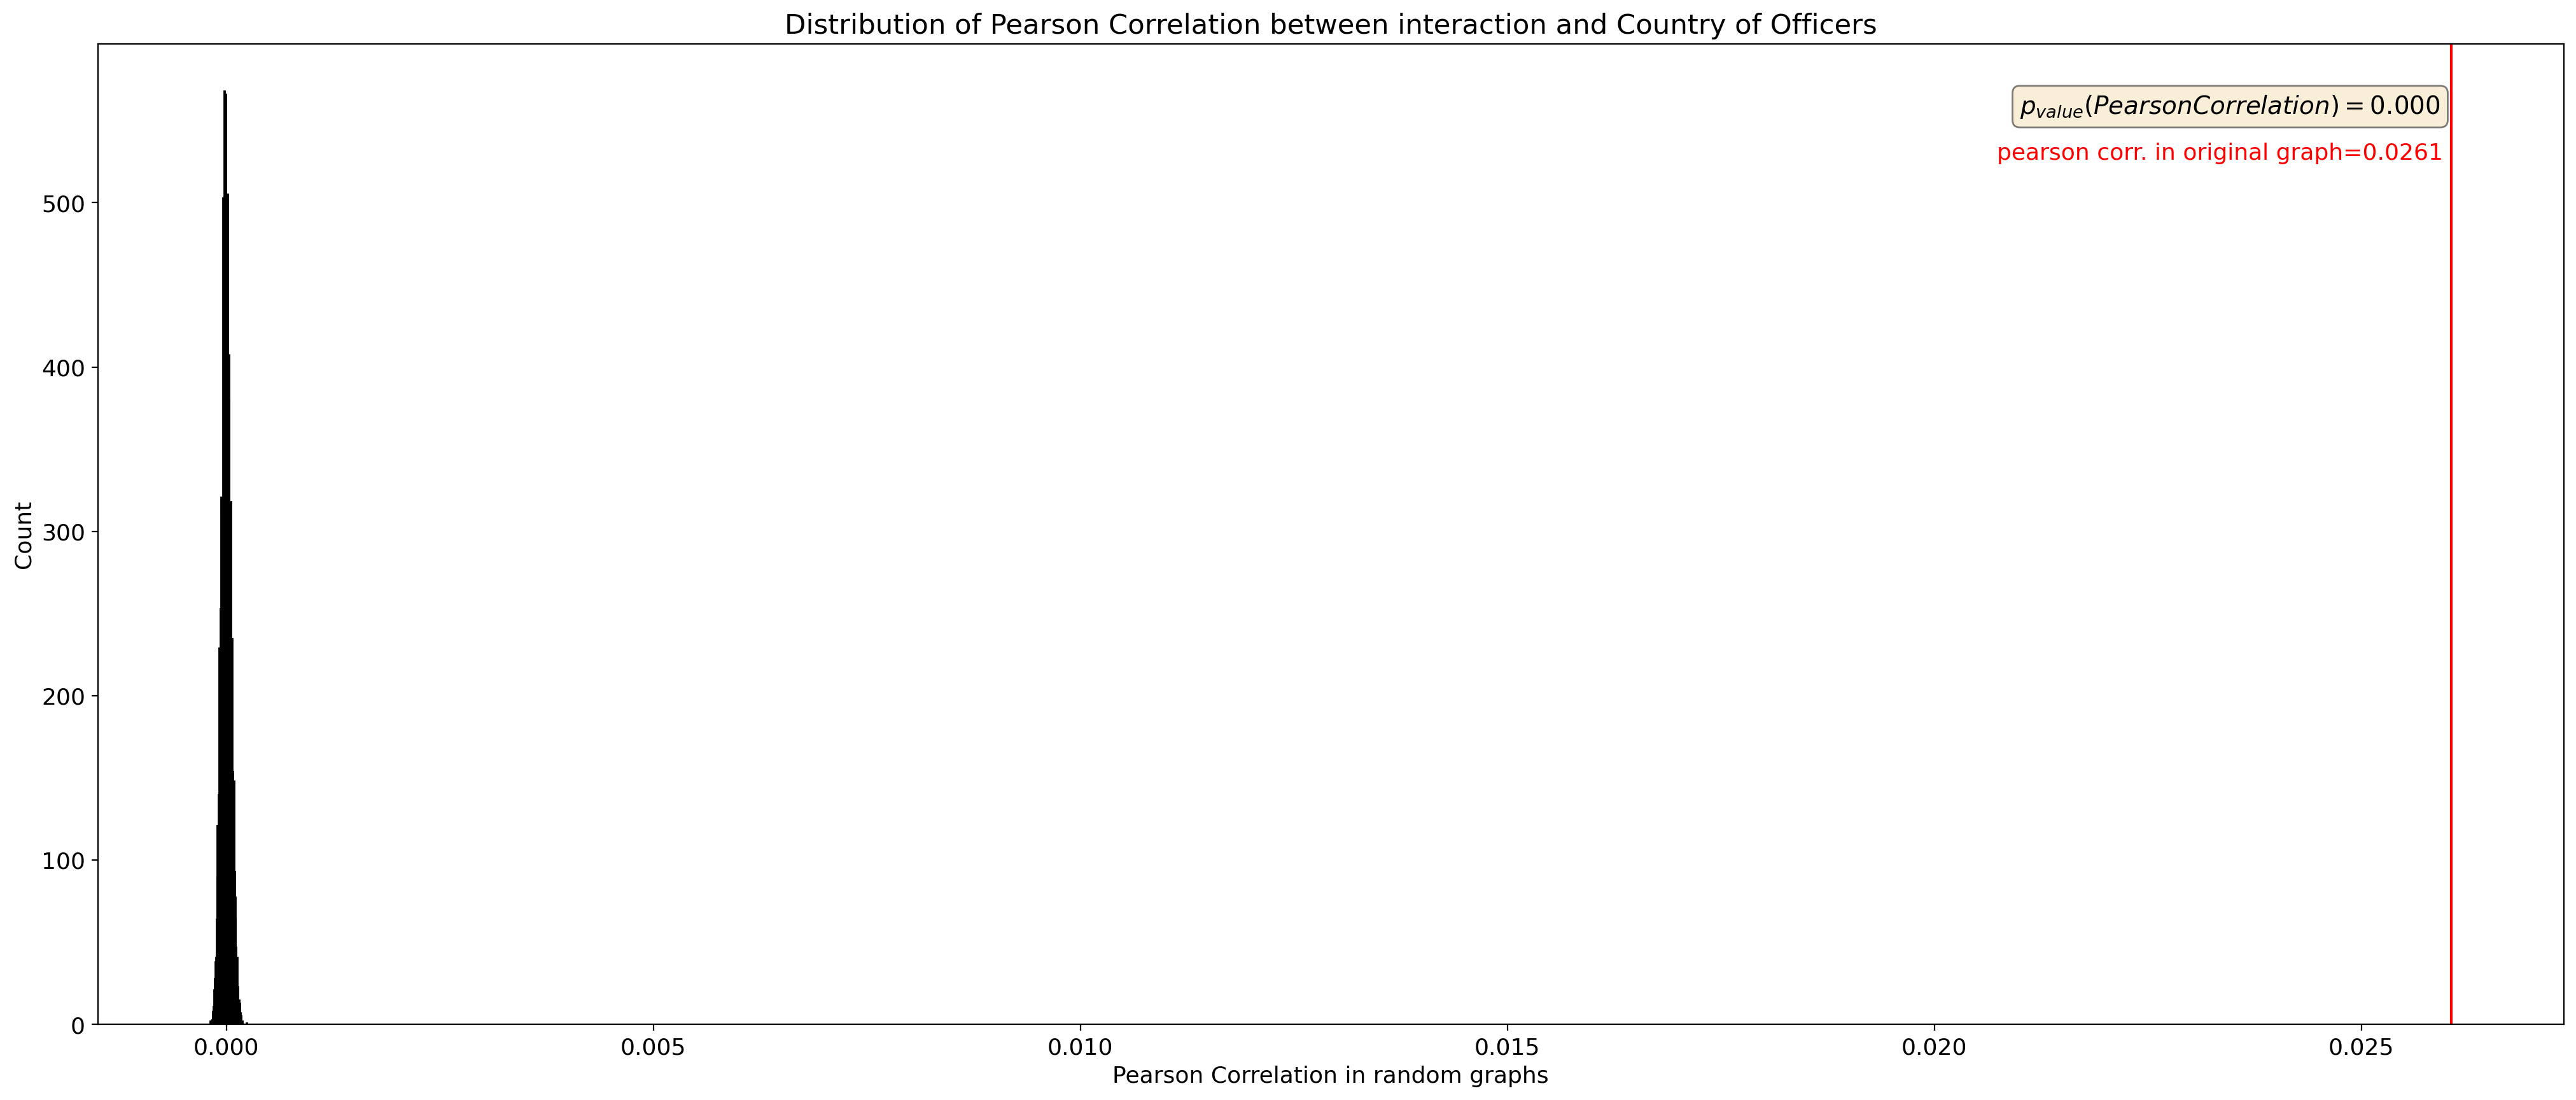

In [12]:
ax = sns.histplot(permutations, x="metric_permuted")
plt.axvline(original, color="red")
plt.text(
    original - 0.0001,
    plt.gca().get_ylim()[1] * 0.9,
    "pearson corr. in original graph=" + str(round(original, 4)),
    color="red",
    verticalalignment="top",
    horizontalalignment="right",
)

textstr = r"$p_{value}(Pearson Correlation)=%.3f$" % (
    (permutations["metric_permuted"] >= original).sum() / len(permutations),
)
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

# place a text box in upper left in axes coords
ax.text(
    0.95,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
)

plt.title("Distribution of Pearson Correlation between interaction and Country of Officers")
plt.xlabel("Pearson Correlation in random graphs")
plt.show()

Im obigen Plot ist die Verteilung der Pearson Korrelation zwischen Interaktion und der Landeszugehörigkeit der Officers in zufälligen Graphen als Histogramm dargestellt. Diese zufälligen Graphen wurden durch einen Permutationstest mit 10.000 Durchläufen erstellt. Die rote Linie repräsentiert die Pearson Korrelation im ursprünglichen Graphen. Es ist deutlich zu sehen, dass sich die zufälligen Korrelationen viel weiter links von der Original-korrelation befindet.  
Auch das P-value von 0.000 zeigt, dass es sich dabei um eine signifikante Korrelation handlet.  

Allerdings ist die Korrelation relativ schwach, weshalb nicht von einem grossen Zusammenhang zwischen Interaktion und Landeszugehörigkeit gesprochen werden kann.

$$
\begin{align*}
H_0 &: \text{Officer\ Interaktion} \leq \text{Officer\ Interaktion}_{\text{zufällig}} \\
H_1 &: \text{Officer\ Interaktion} > \text{Officer\ Interaktion}_{\text{zufällig}}
\end{align*}
$$

Das P-value zeigt, dass $H_0$ abgelehnt und $H_1$ angenommen werden kann.

# Haben schweizer Officers mehr Verbindungen innerhalb der Schweiz?

In diesem Hypothesentest wird das Verhältnis zwischen den Interaktionen schweizer Officers mit anderen schweizer Officers (Interaktion = Beide Officers sitzen im gleichen Vorstand einer Firma) und der totalen Anzahl Interaktionen schweizer Officers zu anderen Officers als Zielmetrik verwendet.  

Diese soll Aufzeigen, wieviel Prozent der Interaktionen innerhalb der Schweiz bleiben und wieviele ins Ausland gehen.

Es wird eine Irrtumswahrscheinlichkeit von 5% festgelegt.

In [13]:
officer_countries, mapper = utils.global_view(officer_officer, "country_codes", self_loops=True)

Global view wobei alle Officers eines Landes als eine Node dargestellt wird.  
Eine self loop bedeute eine Interaktion zwischen zwei Officers im gleichen Land.

In [14]:
def permutation_test_ratio(G: nx.Graph, target_node: str, n: int = 20000):
    def get_relative_connections_to_self(G:nx.Graph, node:str): 

        degree = nx.degree(G, node)

        # if edges available
        if degree:
            return nx.number_of_selfloops(G.subgraph([node])) / degree
        
        # no edges
        return np.nan

    # calculate original ratio
    orig_ratio = get_relative_connections_to_self(G, target_node)

    runs = []
    for _ in tqdm(range(n)):
        # permute graph
        G_ = utils.permute_graph_QAP(G, self_loops=True)

        # calculate ratio
        ratio = get_relative_connections_to_self(G_, target_node)

        runs.append({"ratio": ratio})

    return {
        "original_ratio": orig_ratio,
    }, pd.DataFrame.from_records(runs)


original, permutations = permutation_test_ratio(
    officer_countries.copy(), mapper["CHE"]
)

  0%|          | 0/20000 [00:00<?, ?it/s]

In der obigen Zelle wird simuliert, wie gross das Verhältnis bei Graphen mit zufälligen Interaktionen ausfällt.

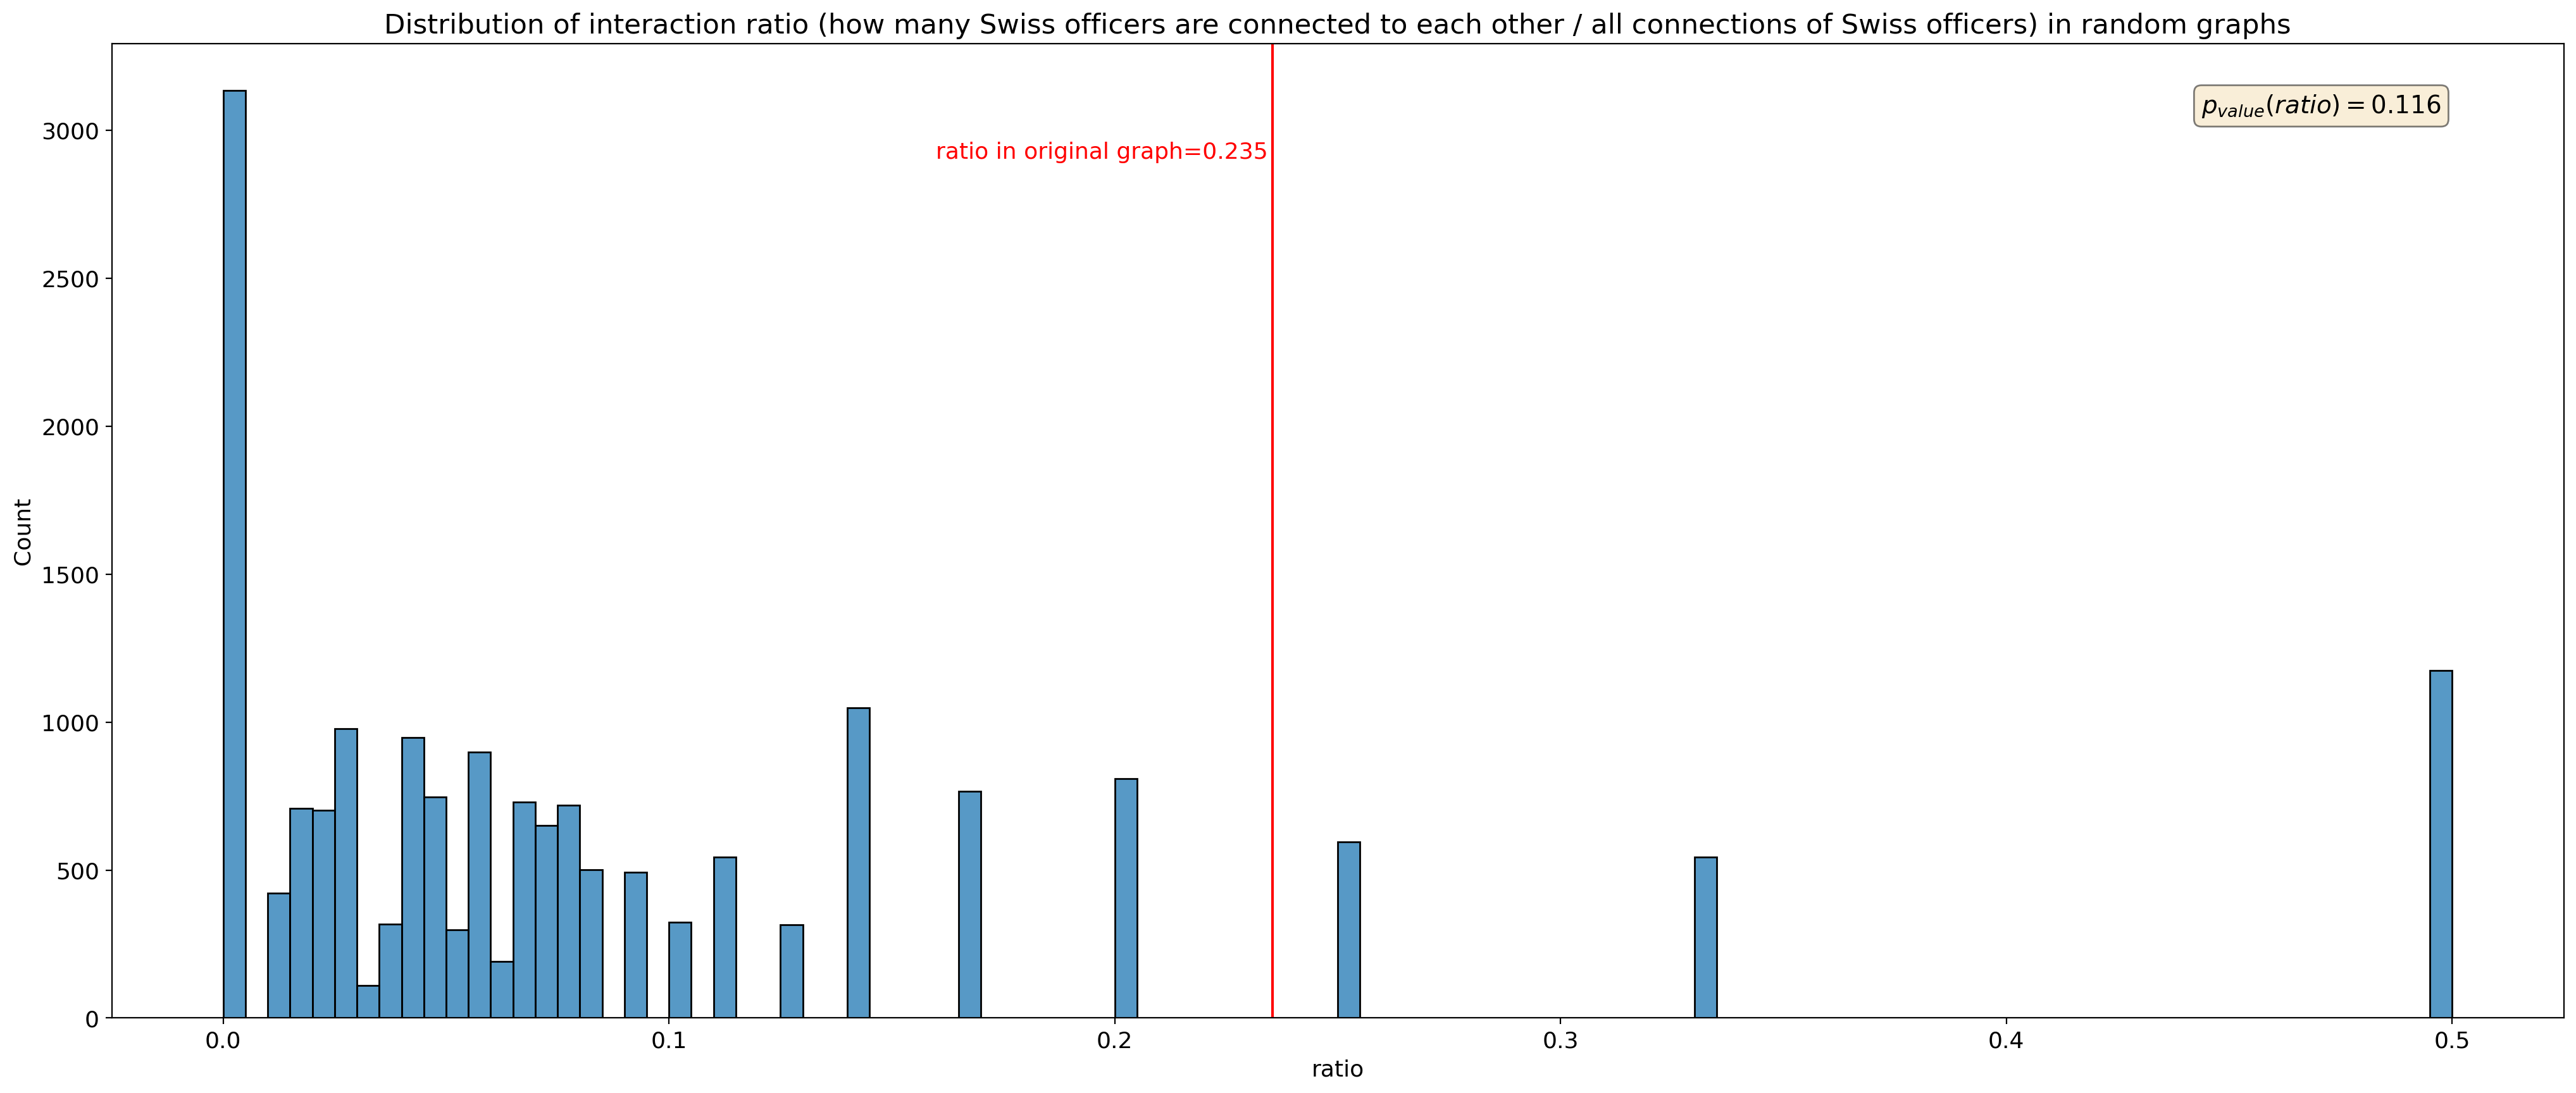

In [15]:
ax = sns.histplot(permutations, x="ratio", bins=100)
plt.axvline(original["original_ratio"], color="red")
plt.text(
    original["original_ratio"] - 0.001,
    plt.gca().get_ylim()[1] * 0.9,
    "ratio in original graph=" + str(round(original["original_ratio"], 3)),
    color="red",
    verticalalignment="top",
    horizontalalignment="right",
)
plt.title("Distribution of interaction ratio (how many Swiss officers are connected to each other / all connections of Swiss officers) in random graphs")

textstr = r"$p_{value}(ratio)=%.3f$" % (
    (permutations["ratio"] >= original["original_ratio"]).sum() / len(permutations),
)
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

# place a text box in upper left in axes coords
ax.text(
    0.95,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
)

plt.xlabel("ratio")
plt.show()

Im obigen Plot ist die Verteilung des Verhältnisses der Anzahl Verbindungen zwischen schweizer Officers und totale Anzahl Verbindungen von schweizer Officers zu erkennen.  
Das Histogram zeigt dabei die Verteilung des Verhältnisses bei zufälligen Graphen.  

Das Verhältnis von 0.235 bedeutet, dass die schweizer Officers nur zu 23.5% mit anderen inlänischen Officers zusammen eine Offshore-firma führen.  
Bedeutet also ein Grossteil sitzt mit ausländischen Officers im Vorstand einer Firma.  

$$
\begin{align*}
H_0 &: \text{Verhältnis} \leq \text{Verhältnis}_{\text{zufällig}} \\
H_1 &: \text{Verhältnis} > \text{Verhältnis}_{\text{zufällig}}
\end{align*}
$$

Der Hypothesentest zeigt allerdings, dass das erhaltene Ergebnis nicht statistisch signifikant ist und somit $H_0$ nicht abgelehnt werden kann.